In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


In [6]:
#  Models 
model1 = tf.keras.models.load_model("baseline_model.keras")
model2 = tf.keras.models.load_model("mobilenet_augmented.keras")
model3 = tf.keras.models.load_model("resnet_model.keras")

In [7]:
# Load Validation Data 
image_size = (180, 180)
batch_size = 16

data_dir = "food_6"
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical"
)

# Prefetch for performance
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 400 files belonging to 4 classes.
Using 80 files for validation.


In [9]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Step 1: Collect true labels and predicted probabilities
y_true = []
y_pred1 = []  # Baseline model predictions
y_pred2 = []  # Augmented model predictions
y_pred3 = []  # ResNet model predictions

for images, labels in val_ds:
    y_true.append(labels.numpy())
    
    y_pred1.append(model1.predict(images))
    y_pred2.append(model2.predict(images))
    y_pred3.append(model3.predict(images))

# Step 2: Convert lists to arrays
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
y_pred2 = np.concatenate(y_pred2)
y_pred3 = np.concatenate(y_pred3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


2025-07-31 01:19:59.598462: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
#  Compute ROC Curves and AUC for Each Model 
def compute_macro_roc_auc(y_true, y_scores, label="Model"):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_true.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    return all_fpr, mean_tpr, macro_auc

fpr1, tpr1, auc1 = compute_macro_roc_auc(y_true, y_pred1, "Baseline ")
fpr2, tpr2, auc2 = compute_macro_roc_auc(y_true, y_pred2, "Augmented ")
fpr3, tpr3, auc3 = compute_macro_roc_auc(y_true, y_pred3, "ResNet")



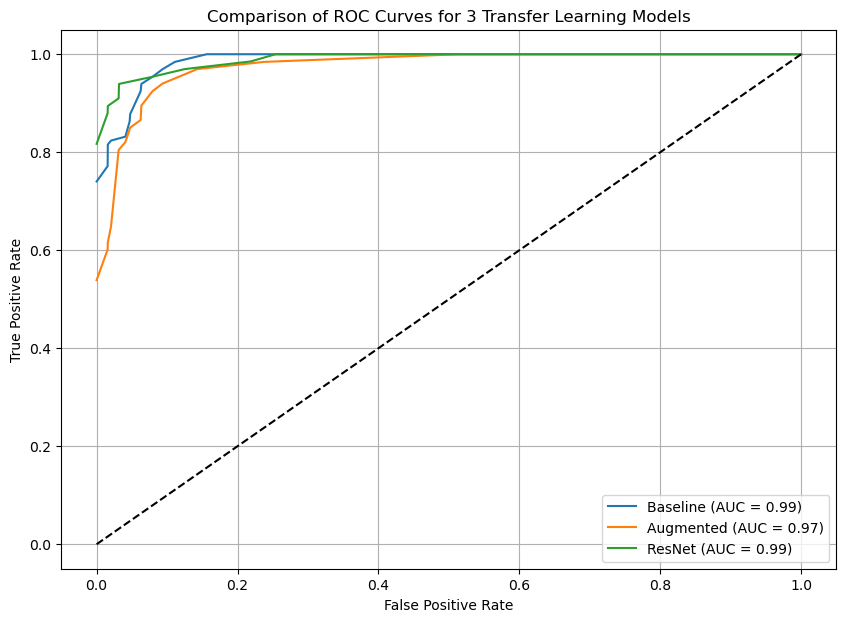

In [11]:
#  Plot ROC Curves 
plt.figure(figsize=(10, 7))
plt.plot(fpr1, tpr1, label=f"Baseline (AUC = {auc1:.2f})")
plt.plot(fpr2, tpr2, label=f"Augmented (AUC = {auc2:.2f})")
plt.plot(fpr3, tpr3, label=f"ResNet (AUC = {auc3:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparison of ROC Curves for 3 Transfer Learning Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
